In [148]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [149]:
def make_bilinear_weights(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    return torch.from_numpy(filt.astype(np.float32))

class Upsample(nn.Module):
    def __init__(self, stride, dim):
        super(Upsample, self).__init__()
        self.stride = stride
        self.conv0 = nn.Conv2d(dim, 128, kernel_size=3, padding=1, bias=False)
        self.conv1 = nn.Conv2d(128, stride**2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self._init_params()

    def _init_params(self):
        self.conv0.weight.data.normal_(std=0.01)
        self.conv1.weight.data.normal_(std=0.01)
        kernel = make_bilinear_weights(self.stride)
        self.conv1.bias.data = kernel.flatten()
    
    def forward(self, x):
        N, C, H, W = x.shape
        stride = self.stride

        # generate upsample kernel
        kernel = self.relu(self.conv0(x))
        kernel = self.relu(self.conv1(kernel))

        # N stride**2 H W -> N H W stride**2
        kernel = kernel.permute(0, 2, 3, 1)
        kernel = kernel.contiguous()
        # N H W stride**2 -> N*H*W 1 stride**2
        kernel = kernel.view(N*H*W, 1, self.stride**2)

        # apply upsampling
        # N C H W -> N H W C
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
        # N H W C -> N*H*W C 1
        x = x.view(N*H*W, C, 1)
        
        # N H W C stride stride
        output = torch.bmm(x, kernel).view(N, H, W, C, stride, stride)
        # N H W C stride stride -> N C H stride W stride
        output = output.permute(0, 3, 1, 4, 2, 5)
        output = output.contiguous()
        # N C H stride W stride -> N C H*stride W*stride
        output = output.view(N, C, H*self.stride, W*self.stride)

        return output

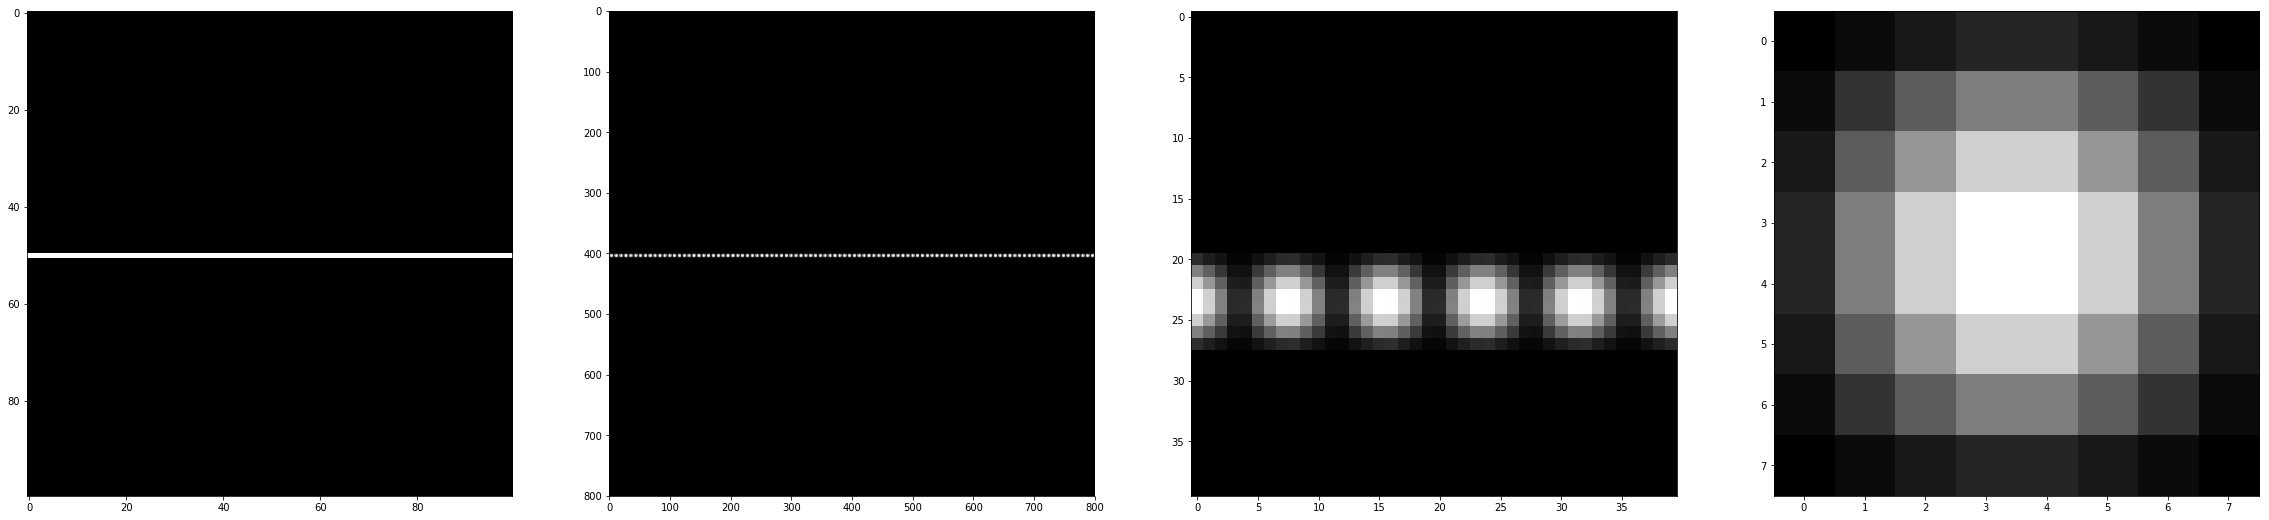

In [150]:
stride = 8
dim = 3

upsample = Upsample(stride=8, dim=3)
feature = torch.zeros(2, dim, 100, 100)
feature[:, :, 50, :] = 1
up = upsample(feature)

feature = feature[1,1]
up = up[1,1]
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
axes[0].imshow(feature.squeeze().detach().numpy(), cmap=cm.Greys_r)
axes[1].imshow(up.squeeze().detach().numpy(), cmap=cm.Greys_r)
axes[2].imshow(up.squeeze().detach().numpy()[50*stride-20:50*stride+20, 50*stride-20:50*stride+20], cmap=cm.Greys_r)
axes[3].imshow(upsample.conv1.bias.data.view(stride, stride).numpy(), cmap=cm.Greys_r)

In [151]:
def make_bilinear_weights(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    return torch.from_numpy(filt.astype(np.float32))

class Upsample1(nn.Module):
    def __init__(self, stride, dim):
        super(Upsample1, self).__init__()
        self.stride = stride
        self.kernel_size = 2 * stride - 1

        self.conv0 = nn.Conv2d(dim, 128, kernel_size=3, padding=1, bias=False)
        self.conv1 = nn.Conv2d(128, self.kernel_size**2, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)

        self._init_params()

    def _init_params(self):
        self.conv0.weight.data.normal_(std=0.01)
        self.conv1.weight.data.normal_(std=0.01)
        kernel = make_bilinear_weights(self.kernel_size)
        self.conv1.bias.data = kernel.flatten()
    
    def forward(self, x):

        N, C, H, W = x.shape

        kernel = self.relu(self.conv0(x))
        kernel = self.relu(self.conv1(kernel))

        pad = (self.kernel_size-1)//2
        y = torch.zeros(N, C, H*self.stride, W*self.stride, device=x.device)
        y = nn.functional.pad(y, [pad, pad, pad, pad])

        
        for i in range(0, H):
            for j in range(0, W):

                x1 = x[:, :, i, j]
                k1 = kernel[:, :, i, j]

                x1 = x1.view(N, C, 1)
                k1 = k1.view(N, 1, self.kernel_size**2)
                y1 = torch.bmm(x1, k1)
                y1 = y1.view(N, C, self.kernel_size, self.kernel_size)

                centery = i * self.stride + pad
                centerx = j * self.stride + pad
                y[:, :, centery-pad:centery+pad+1, centerx-pad:centerx+pad+1] += y1

        return y

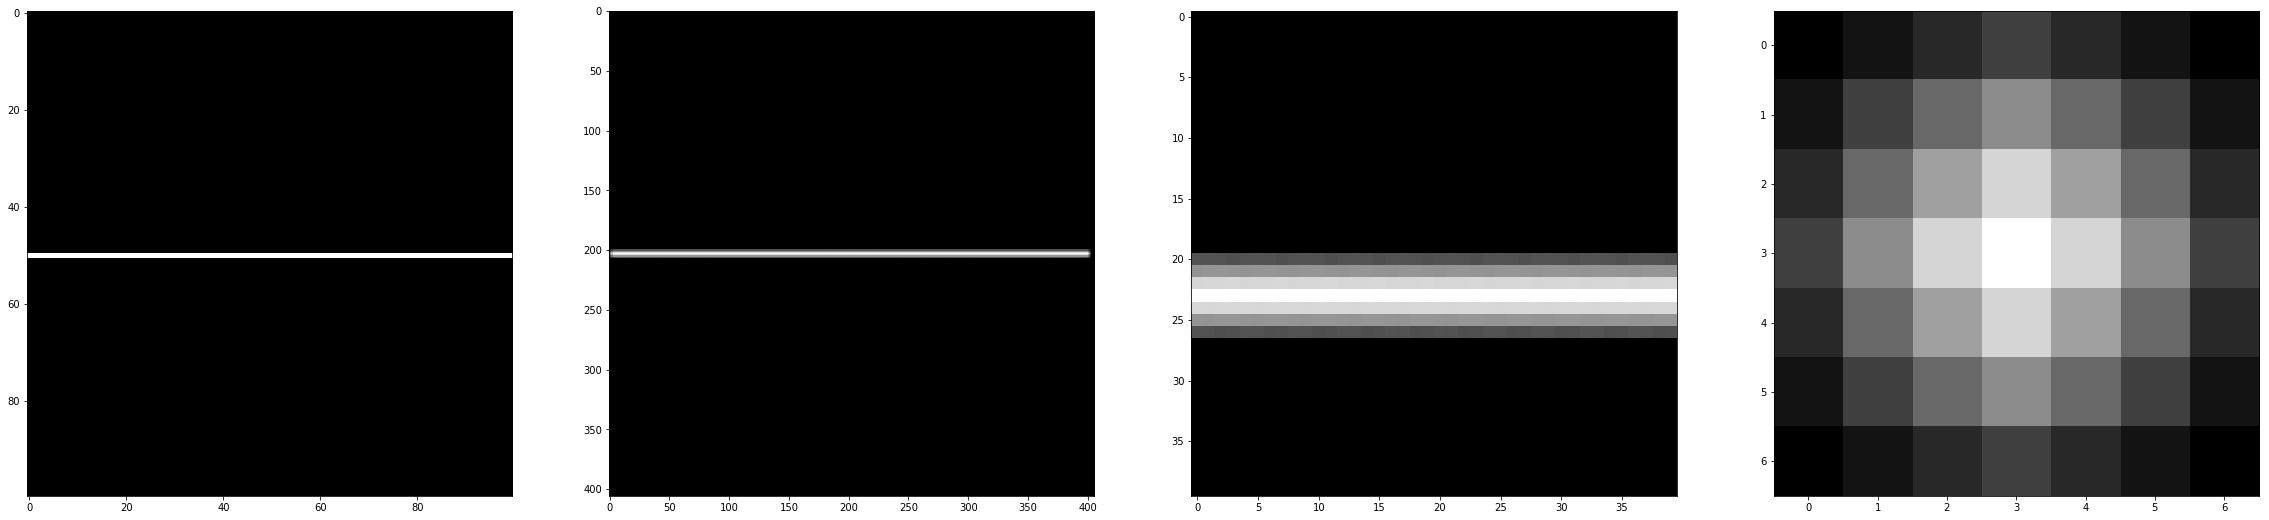

In [152]:
stride = 4
dim = 3
kernel_size = 2 * stride - 1

upsample1 = Upsample1(stride=stride, dim=dim)
feature = torch.zeros(2, dim, 100, 100)
feature[:, :, 50, :] = 1
#feature[:, :, 1, 2] = 1
up = upsample1(feature)

feature = feature[1,1]
up = up[1,1]
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
axes[0].imshow(feature.squeeze().detach().numpy(), cmap=cm.Greys_r)
axes[1].imshow(up.squeeze().detach().numpy(), cmap=cm.Greys_r)
axes[2].imshow(up.squeeze().detach().numpy()[50*stride-20:50*stride+20, 50*stride-20:50*stride+20], cmap=cm.Greys_r)
axes[3].imshow(upsample1.conv1.bias.data.view(kernel_size, kernel_size).numpy(), cmap=cm.Greys_r)

In [154]:
upsample = Upsample(stride=stride, dim=dim).cuda()
upsample1 = Upsample1(stride=stride, dim=dim).cuda()
feature = torch.zeros(2, dim, 100, 100).cuda()

In [157]:
import time
tic = time.time()
for i in range(10):
    upsample(feature)
print(time.time()-tic)

tic = time.time()
for i in range(10):
    upsample1(feature)
print(time.time()-tic)

0.017473936080932617
9.438402652740479
